# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

**Цель исследования**
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* формировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.

**Ход исследования**
* Выгрузка данных
* Исследовательский анализ (EDA)
* Модель прогнозирования оттока клиентов
* Кластеризация клиентов
* Выводы и базовые рекомендации


**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

`Churn` — факт оттока в текущем месяце.

**Импорт необходимых библиотек**

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')  

## Выгрузка данных

In [11]:
df = pd.read_csv('/datasets/gym_churn.csv')

def get_data(df):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    print('Размер датасета:')
    print(df.shape)
    print('________________________________________________________________________')
    print('Общая информация:')
    display(df.info())
    print('________________________________________________________________________')
    print('Первые строки:')
    display(df.head())
    print('________________________________________________________________________')
    print('К-во дубликтов:', df.duplicated().sum())
get_data(df)

Размер датасета:
(4000, 14)
________________________________________________________________________
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  l

None

________________________________________________________________________
Первые строки:


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


________________________________________________________________________
К-во дубликтов: 0


* Датасет размером в  4000 строк и 14 колонок
* Дубликтов и пропусков нет

## Исследовательский анализ (EDA)

### Первый взгляд на предмет отсутствующих признаков, mean и std

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


* Распределение по полу практически одинаковое
* Большая часть людей живет/ работают недалеко от фитнес клуба
* Половина клиентов пришла по партнерским программам
* Мало людей пришло по программе "приведи друга"
* Почти у всех клиентов есть номер телефона
* 41% посещает групповые занятия
* Средний возраст 29 лет
* Среднее значение выручки за доп.услуги = 147
* Среднее значение до конца договора - 4,3 мес, но значения плавают от 1 до 12 мес, поэтому достоверно сказать нельзя.
* Среднее время с момента первого обращения - 3,7 мес
* В среднем люди посещают зал до 2 раз в неделю (за все время)
* По данным за прошлый месяц, люди ходят в зал от 1 до 2 раз в неделю

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [13]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


* Распределение по полу не меняется
* Локация тоже не сильно изменилась, но все-таки в оттоке наблюдается меньше людей, которые живут/работают рядом
* В оттоке меньше людей пришедших по партнерской программе
* Так же почти в 2 раза меньше людей которые пришли по программе "приведи друга"
* В оттоке средний срок аббонемента = 1,7 мес, против 5,7.
* Люди в оттоке почти в 2 раза реже посещают групповые занятия
* Средний возраст чуть меньше 27 против 30
* Денег на доп.услуги они тратят тоже меньше, но не значительно
* Срок до окончания аббонемента больше у оставшихся клиентов
* Среднее к-во посещений меньше чем у оставшихся, как за все время, так и за прошлый месяц

### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [14]:
#Разделим датасет на бинарные и оставшиеся переменные
bin_col = df[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']]
rem_col = df.drop(['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn'], axis=1)

**Распределение бинарных признаков**

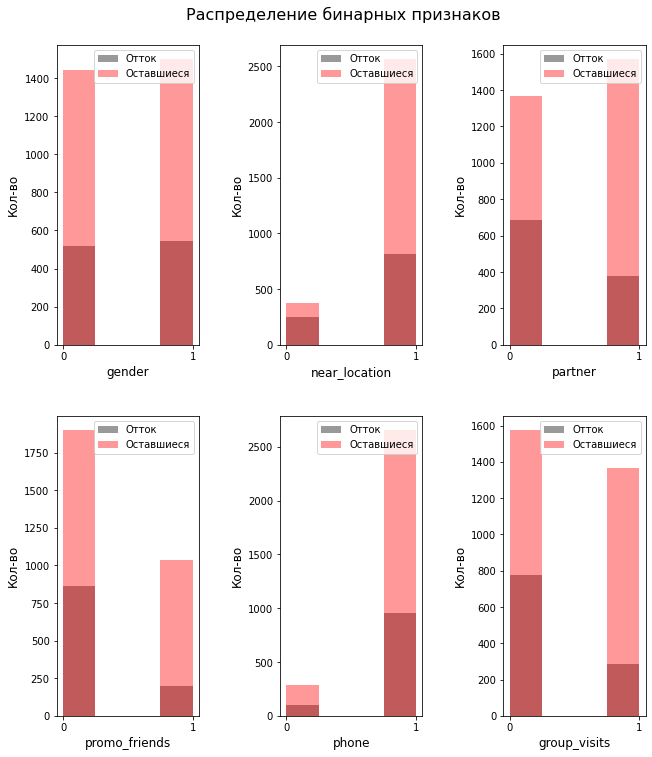

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,11))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение бинарных признаков', fontsize=16)
for i in bin_col:
    ax = axes_list.pop(0)
    sns.distplot(df.query('churn == 1')[i], bins=4, ax=ax, kde=False, color='black',label='Отток')
    sns.distplot(df.query('churn == 0')[i], bins=4, ax=ax, kde=False, color='red',label='Оставшиеся')
    ax.set_xticks([0,1])
    ax.set_xlabel(i, fontsize=12)
    ax.set_ylabel('Кол-во', fontsize=12)
    ax.legend()

* Распределение по полу одинаковое, доли оттока также равные
* Среди локации большее к-во тех, кто живет близко, и доля оставшихся сильно выше
* По параметру `partner` видно, что доля оттока выше у тех, кто не по партнерской программе
* Почти вдвое меньше людей по параметру `promo_friends`, но доля оставшихся больше
* В основом люди оставляют свои номера
* Люди не посещающие групповые занятия чаще уходят, но их немного больше

**Распределение оставшихся признаков**

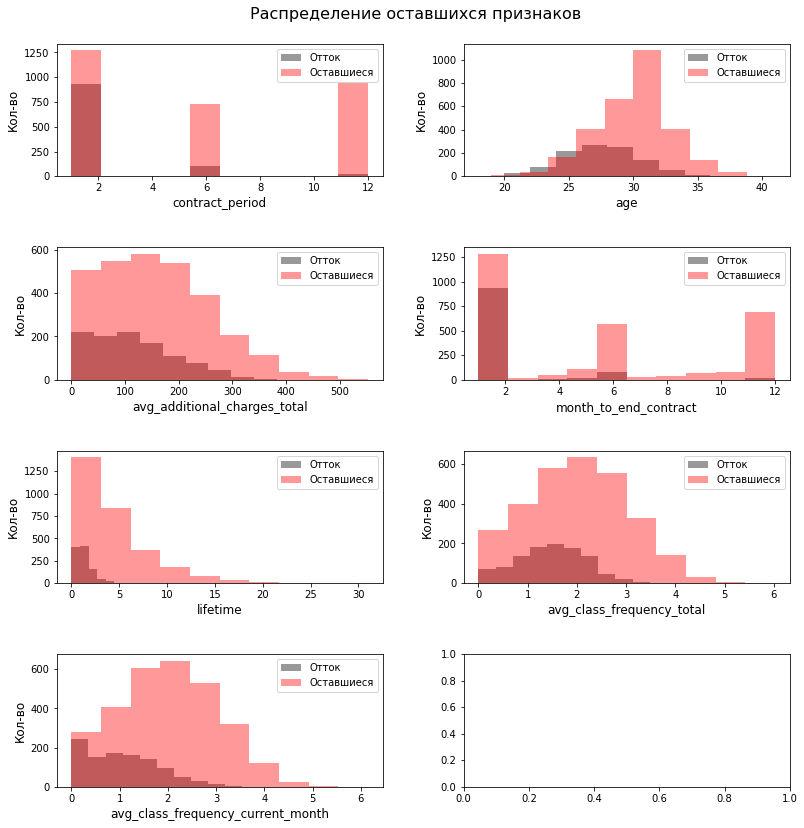

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение оставшихся признаков', fontsize=16)
for i in rem_col:
    ax = axes_list.pop(0)
    sns.distplot(df.query('churn == 1')[i],bins=10,  ax=ax, kde=False, color='black',label='Отток')
    sns.distplot(df.query('churn == 0')[i],bins=10,  ax=ax, kde=False, color='red',label='Оставшиеся')
    ax.set_xlabel(i, fontsize=12)
    ax.set_ylabel('Кол-во', fontsize=12)
    ax.legend()

### Постройте матрицу корреляций и отобразите её.

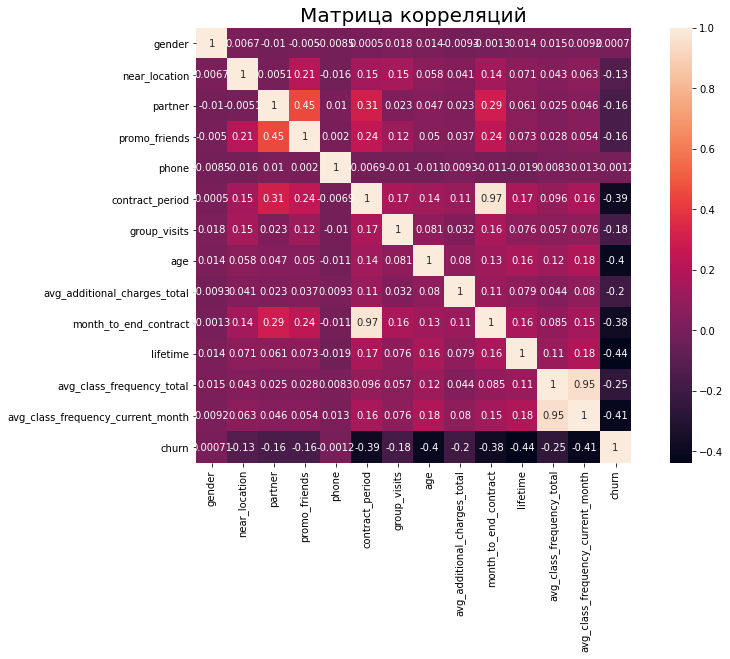

In [17]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True, square=True)
plt.title('Матрица корреляций', fontsize = 20)
plt.show()

* В целом признаки не сильно коррелируют друг с другом, за исключением некоторых:

`promo_friend`, `partner` - 0,45

* И особое внимание стоит уделить признакам:

`avg_class_frequency_total`, `avg_class_frequency_current_month`, `month_to_end_contract`, `contract_period`

Такую сильную корреляцию в 0,95-0,97 стоит учесть в моделях линейной регрессии

## Модель прогнозирования оттока клиентов

### Разбейте данные на обучающую и валидационную выборку функцией

In [20]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# разделим модель на обучающую и валидационную выборку случайным разбиением, т.к нет привязки ко времени
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

# применим стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Обучение модели логистической регрессией и случайным лесом и вывод метрик

In [27]:
# список моделей
model = [LogisticRegression(), RandomForestClassifier()]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
    'Accuracy: {:.3f} Precision: {:.3f} Recall: {:.3f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
        )
    )
#запустим модели
for i in model:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    print()

LogisticRegression()
Accuracy: 0.922 Precision: 0.854 Recall: 0.828

RandomForestClassifier()
Accuracy: 0.911 Precision: 0.836 Recall: 0.798



### Оценка метрик

Обе модели показали хорошие результаты, но модель логистической регрессии оказался немного лучше, а именно:
* `Accuracy` -  0.922 против 0.911 у случайного леса
* `Precision` - 0.854 против 0.836 у случайного леса
* `Recall` - 0.828 против 0.798 у случайного леса


## Кластеризация клиентов

### Стандартизация данных

In [30]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Матрица расстояний и отрисовка дендрограмма

In [32]:
#таблица связок между объектами
linked = linkage(X_sc, method = 'ward')

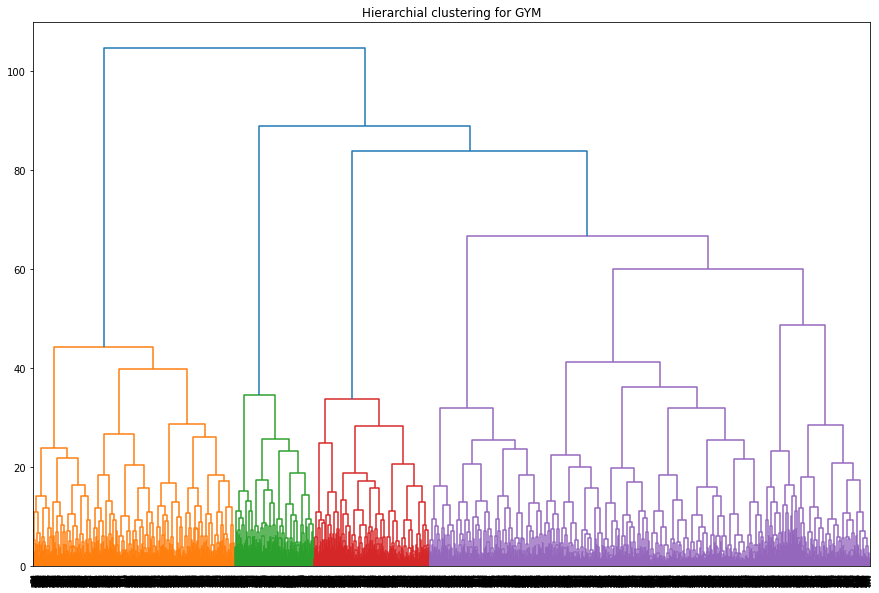

In [33]:
#визуализируем связку дендрограммой
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

**Предложенное оптимальное число кластеров 4**

### Обучение модели кластеризации на основании алгоритма K-Means и прогноз кластеров клиентов.

In [44]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters=5, random_state=0)

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

# добавим кластеры в исходный датасет
df['cluster_km'] = labels

# проверим кластеры методом силуэта
silhouette_score(X_sc, labels) 

0.14140953623023353

Значение метрики силуэта принимает значения от -1 до 1. Чем ближе к 1, тем качественнее кластеризация.

В нашем случае значение - 0,14, что свидетельствует довольно плохой кластеризации

### Рассмотрим средние значения признаков для кластеров

In [112]:
df.groupby(['cluster_km']).agg('mean').T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


* Кластер 0 - высокая доля `partner` и `promo_friends`, средний срок аббонемента - 11 мес и большее к-во оставшихся месяцев до конца аббонемента, много тратят на доп.услуги, но меньше чем 4 кластер - `вероятнее всего, доля оттока будет меньше`
* Кластер 1 - не указан номер, средний срок аббонемента - 4 мес
* Кластер 2 - живут/работают в удаленности от клуба, пришли не от друзей, меньше всех посещают групповые
* Кластер 3 - в кластере люди которые в обязательном порядке живут/работают рядом с клубом, меньший срок аббонемента, меньше всех тратят на доп. услуги, меньше всего посещают зал за неделю - `вероятнее всего, доля оттока будет больше`
* Кластер 4 - больше всех посещают зал за неделю, много тратят на доп. услуги, живут зачастую рядом, самы высокий lifetime, старше всех, меньшее среднее среди `partner` и `promo_friends` - `вероятнее всего, доля оттока будет меньше`


###  Распределения признаков для кластеров

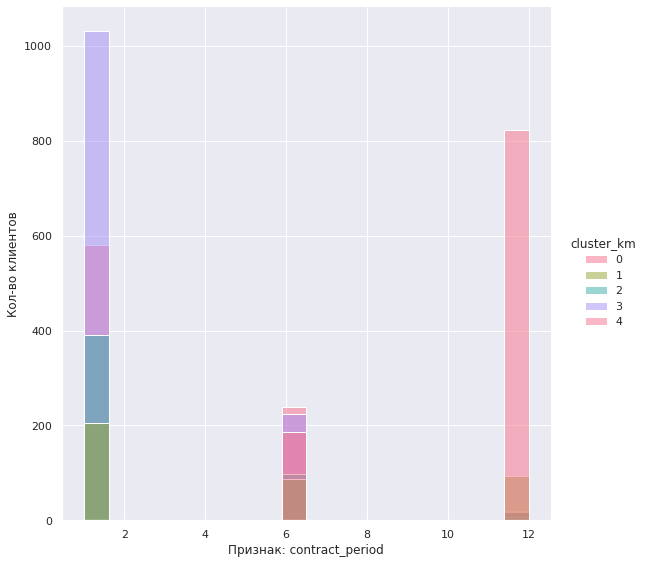

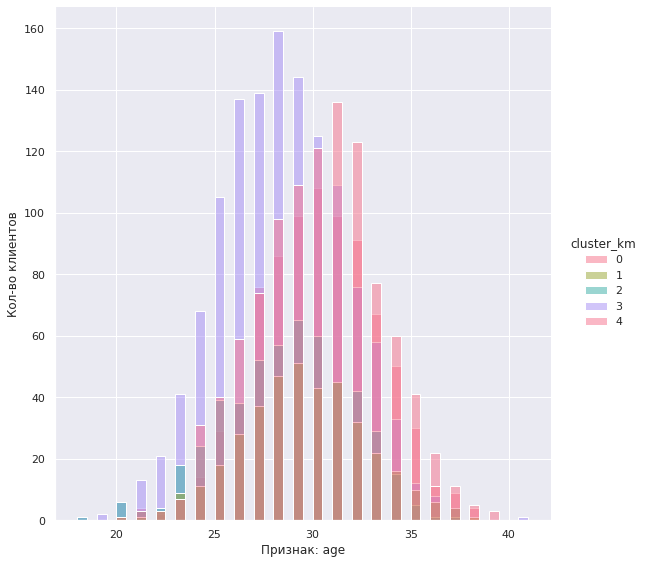

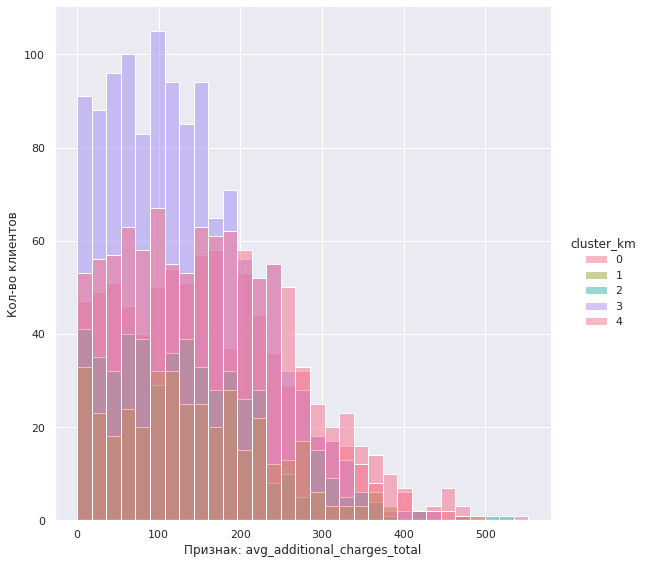

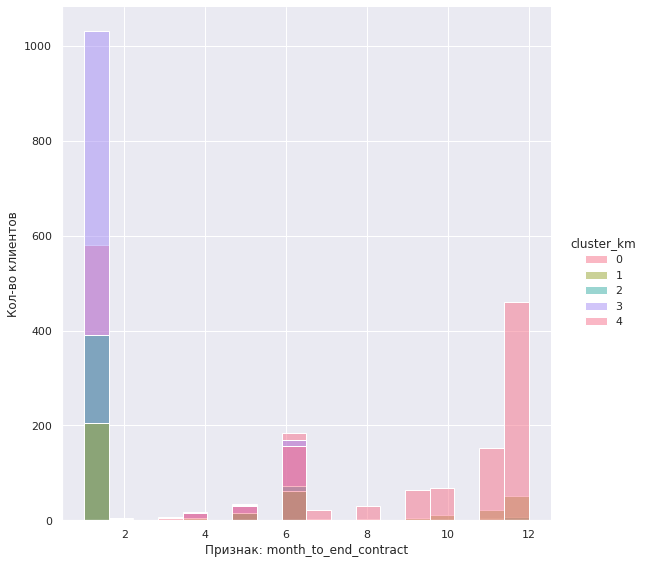

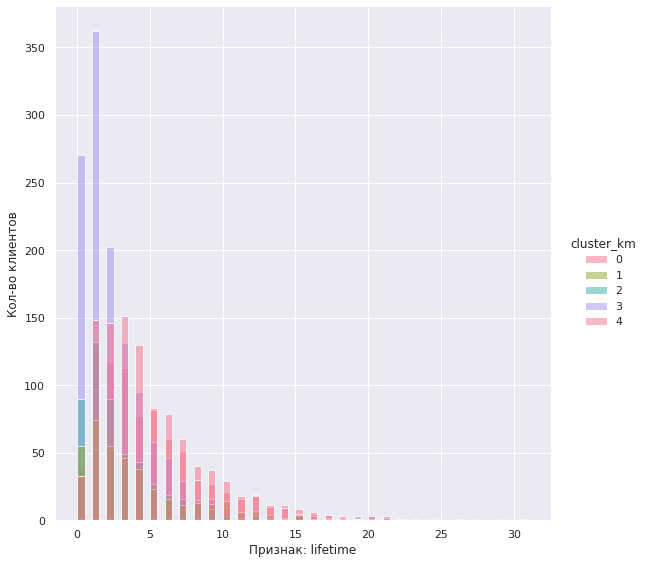

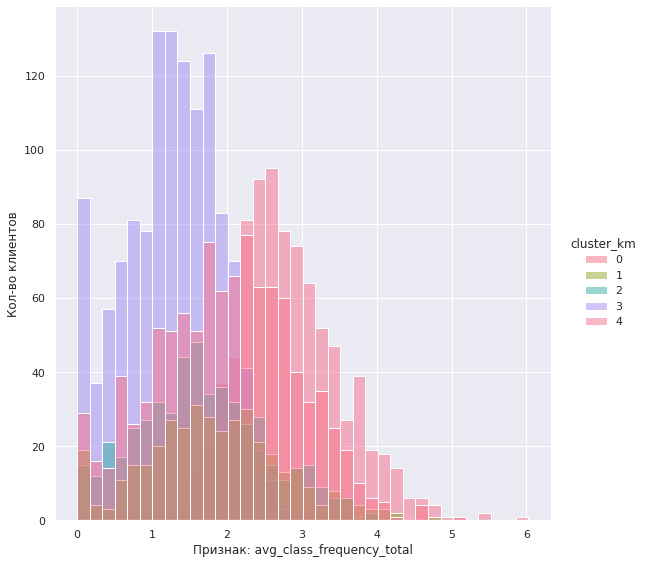

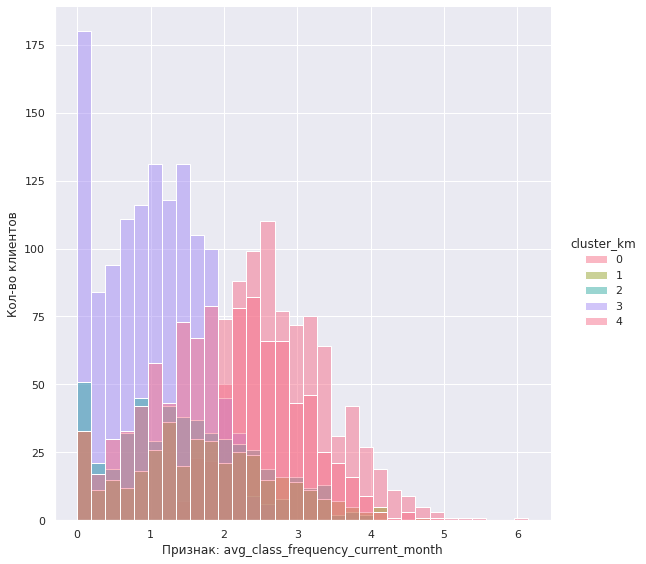

In [92]:
for f in rem_col:
    sns.displot(df, x=df[f], hue='cluster_km', kind='hist', height = 8, palette='husl')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel('Признак: {}'.format(f))

* `conract_period` - 3 кластер лидирует среди аббонементов до 2 мес, 0 кластер - до 12 мес
* `age` - также выбивается 3 и 0 кластер. 3 кластер 23-30 лет, 0 кластер 26-35 лет
* `avg_additional_charges_total` - выбиваются 3 и 4 кластеры. 3 тратит до 100, четвертый до 60
* `month_to_end_contract` - особенно выделяется 3 кластер. 0 кластер тоже фигурирует в разных значениях
* `lifetime` - очень выделяется 3 кластер но в минимальных значениях этого признака
* `avg_class_frequency_total` и `avg_class_frequency_current_month` - приблизительно равны и так же выделяются 3 и 0 кластер. 3 до 2 раз, 0 до 4 раз

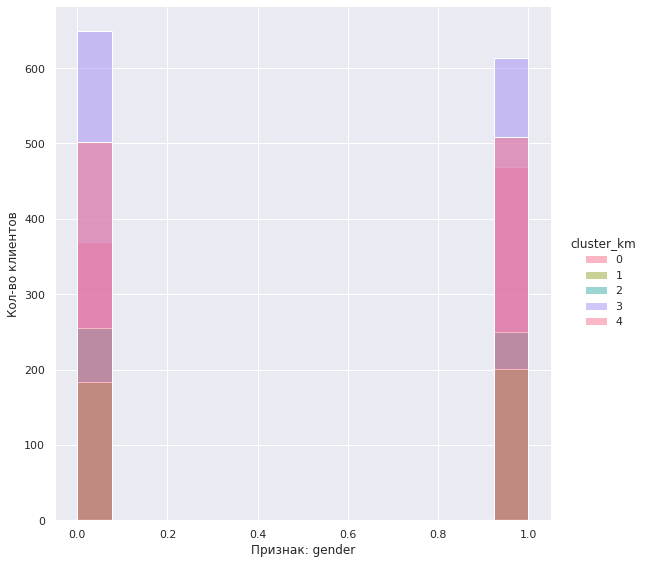

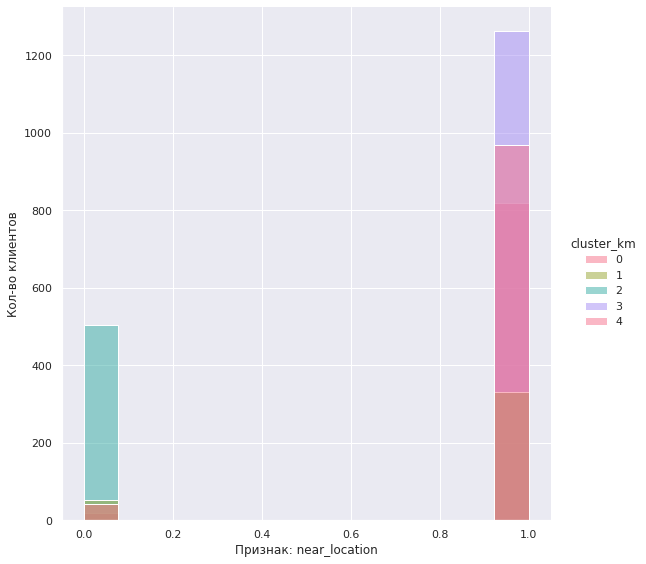

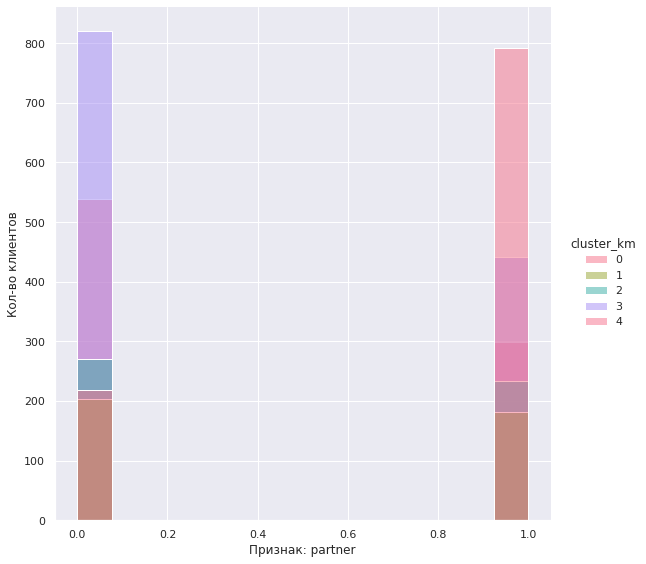

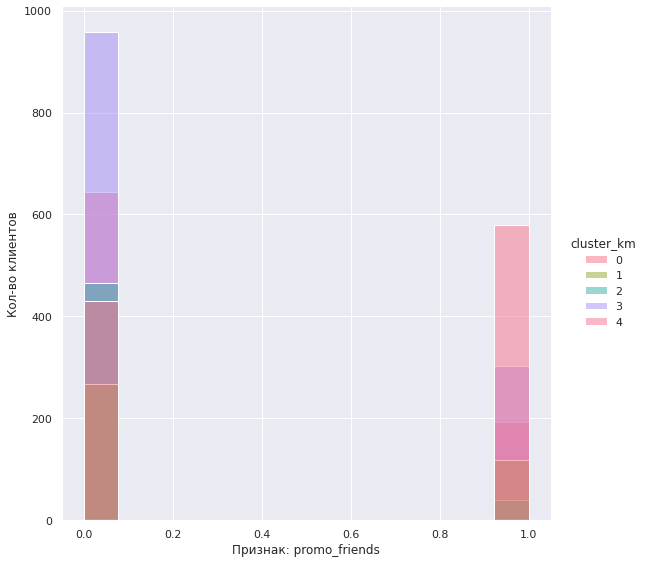

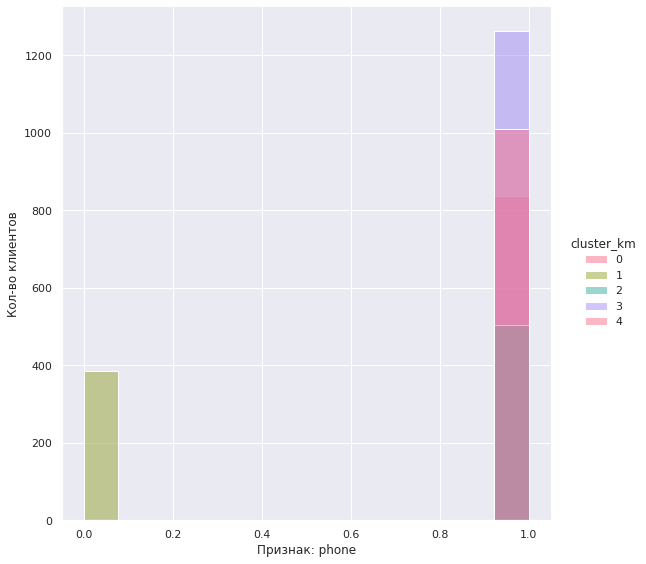

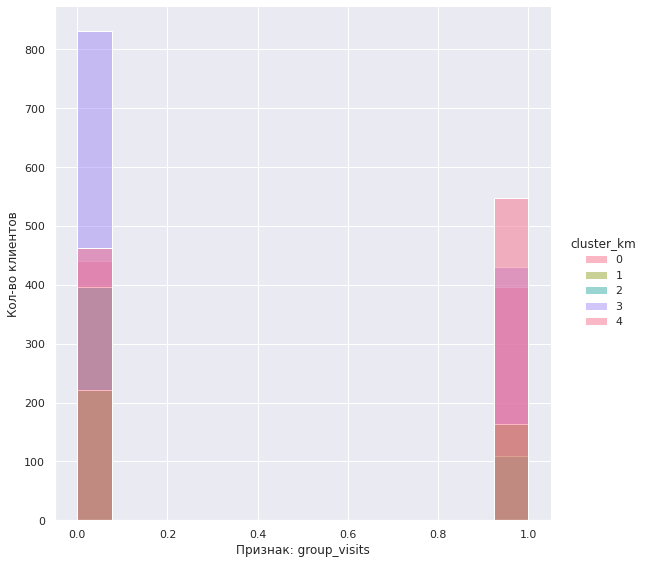

In [93]:
for f in bin_col:
    sns.displot(df, x=df[f], hue='cluster_km', kind='hist', height = 8, palette='husl')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel('Признак: {}'.format(f))

* `near_location` - здесь выделяется 2 кластер, где люди удалены от клуба, почти все остальные живут/работают рядом
* `partner` - 3 и 0 кластеры, 3 в основном не по партнерской, 0 наоборот
* `promo_friends` - тех кто пришел через друзей, почти вдвое меньше, но и тут 3 и 0 кластеры лидируют, 0 через друзей, 3 наоборот
* `group_visits` - 3 и 0 кластеры, 3 не посещает, 0 посещает

### Доля оттока для каждого кластера

In [109]:
df[df['churn'] == 1].groupby('cluster_km')['gender'].agg('count')/df[df['churn'] == 1]['gender'].count()*100

cluster_km
0     2.639020
1     9.707823
2    21.112158
3    61.168709
4     5.372290
Name: gender, dtype: float64

* Кластеры 0, 1 и 4 наименее склонны к оттоку, что видно по их долям 2,63; 9,7; 5.37, соответственно
* Кластеры 2 и 3 наиболее склонны к оттоку, доли: 21,11; 61.16 соответственно

**Кластер 0 наиболее надежен, следом 4 и 1**

## Вывод

**Предобработка**
* Данные изучены и подготовлены

**Прогнозирование**
* При прогнозировании были использованы 2 модели: логистическая регрессия и случайный лес, обе модели показали хорошие результаты, но логистическая регрессия оказалась немного лучше:
    - `Accuracy` -  0.922 против 0.911 случайного леса
    - `Precision` - 0.854 против 0.836 случайного леса
    - `Recall` - 0.828 против 0.798 случайного леса
    
**Кластеризация**
* Провели кластеризацию, разбили на 5 кластеров:
    - 0 кластер 
        - Наиболее надежный кластер, доля оттока 2,64%. Находится рядом, зачастую приходят по партнерской/приведи друга программам, наибольший средний срок аббонемента ~11, часто посещают групповые занятия, много тратят на доп.услуги, средний срок до конца аббонемента - 10 мес, зал посещают до 2 раз в неделю
    - 1 кластер
        - Третий по надежности кластер, доля оттока 9,7%. Живут/работают рядом, не так часто приходят по партнерской/приведи друга программам, средний срок аббонемента 4,8, довольно часто посещают групповые, на доп услуги тратят много, но меньше чем 0 и 4 кластеры, средний срок до конца аббонемента - 4,5 мес, зал посещают до 2 раз в неделю
    - 2 кластер
        - Плохой, но не худший кластер, доля оттока 21.11%. Живут/работают совсем не рядом, не так часто приходят по партнерской программе, почти нет людей пришедших по программе приведи друга, средний срок аббонемента - 2,4 мес, меньше всех посещают групповые занятия, почти меньше всех тратят на доп.услуги,  средний срок до конца аббонемента - 2,2 мес, зал посещают до 1,7 раза в месяц.
    - 3 кластер
        - Самый плохой кластер, доля оттока 61.16%. Зал посещают редко, до 1 раза. Самый маленький срок аббонемента, меньше всего тратят на доп услуги. Средний срок до окончания аббонемента меньше всех 1.9
    - 4 кластер
        - Второй по надежности кластер, доля оттока 5,37%. В этом кластере люди больше всех посещают зал, до 3 раз. Маленький средний срок аббонемента, до 2.7 мес, но больше всех тратят на доп.услуги, любят групповые занятия. Не очень любят партнерские/приведи друга программы.
        
**Рекомендации**
* Уделить внимание аббонементам по 12 мес, сделать привлекательнее цены или доп.условия, люди с такими аббонементами реже всего покидают зал
* Уделить внимание партнерским/приведи друга программам, пришедшие по ним, тоже редко уходят, но в большей степени это относится к партнерским программам, таким как: абонемент фитнес клуба от компании.
* Завлекать людей на групповые занятия, расширить разновидности занятий и тд
* Меньше тратить времени на людей старше 29 лет и живущих/работающих не в радиусе фитнес клуба
